In [1]:
"""
Mask R-CNN - Multiclass - Coco style annotations in JSON format
For annotations, use one of the following programs: 
    https://www.makesense.ai/
    https://labelstud.io/
    https://github.com/Doodleverse/dash_doodler
    http://labelme.csail.mit.edu/Release3.0/
    https://github.com/openvinotoolkit/cvat
    https://www.robots.ox.ac.uk/~vgg/software/via/
    
"""

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

Using TensorFlow backend.


In [2]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [3]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/home/ubuntu/catkin/lane_segmentation/training/annotations.json', '/home/ubuntu/catkin/lane_segmentation/training/')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/ubuntu/catkin/lane_segmentation/training/annotations.json', '/home/ubuntu/catkin/lane_segmentation/training/')
dataset_val.prepare()

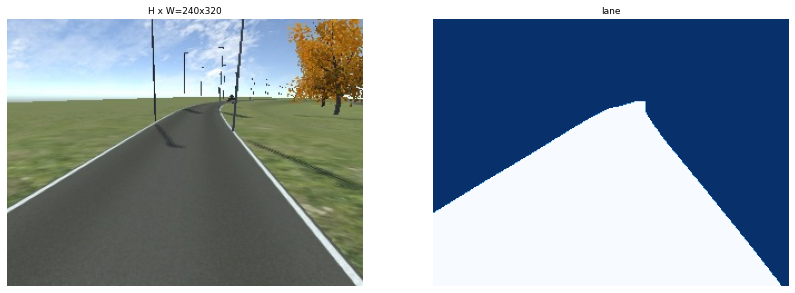

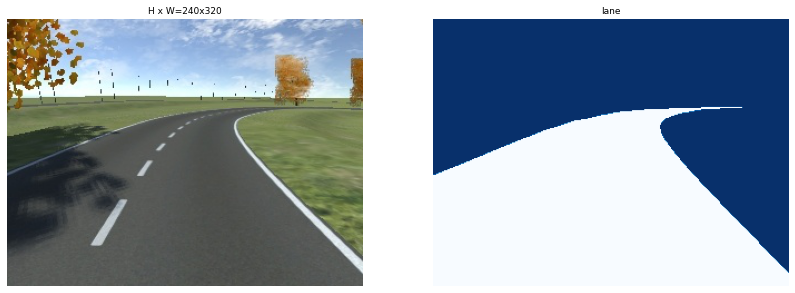

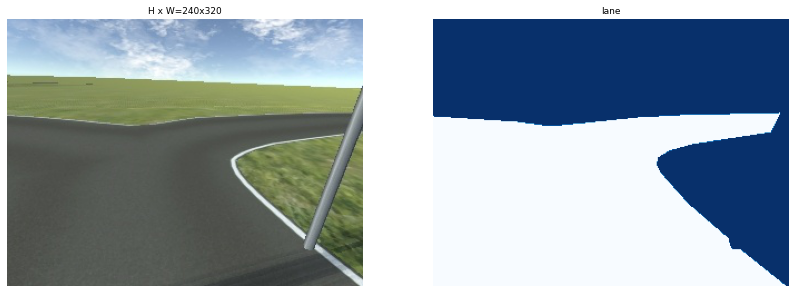

In [4]:
dataset = dataset_train
image_ids = dataset.image_ids
image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)  #limit to total number of classes

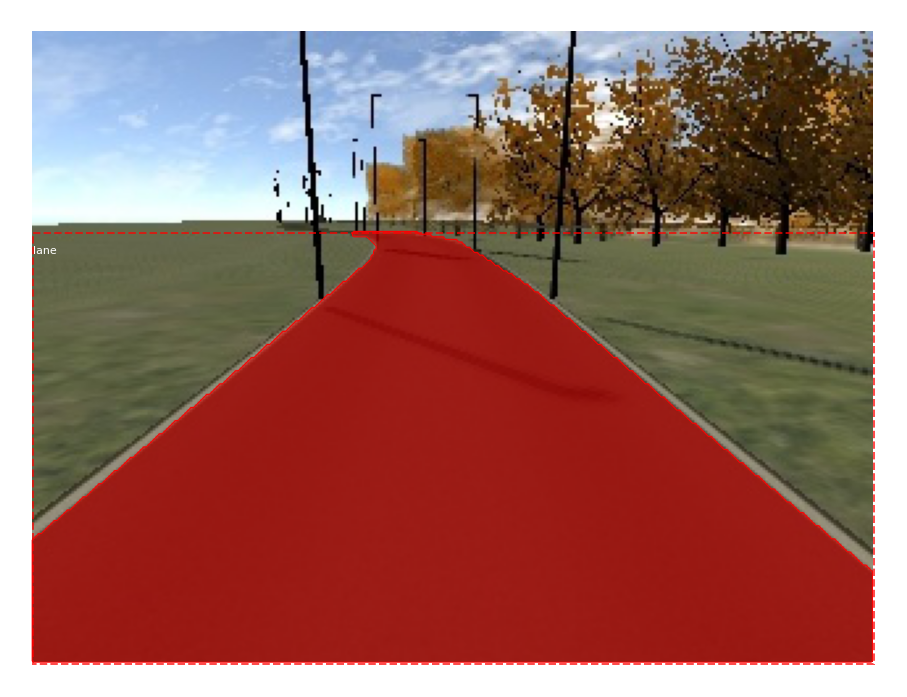

In [5]:
# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [6]:
# define a configuration for the model
class LaneConfig(Config):
	# define the name of the configuration
	NAME = "lane_segmentation"
	# number of classes (background + lane)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = LaneConfig()
config.display() 


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
ROOT_DIR = os.path.abspath("../../")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
WEIGHTS_PATH = "/home/ubuntu/Workspace/Mask_RCNN/logs/lane_segmentation20230505T0903/mask_rcnn_lane_segmentation_0004.h5"

In [8]:
# define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=10, layers='heads')

Instructions for updating:
box_ind is deprecated, use box_indices instead
Re-starting from epoch 4

Starting at epoch 4. LR=0.001

Checkpoint Path: /home/ubuntu/Workspace/Mask_RCNN/logs/lane_segmentation20230505T0903/mask_rcnn_lane_segmentation_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
m

Epoch 5/10
 99/100 [============================>.] - ETA: 18s - loss: 0.2204 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.0432

100/100 [==============================] - 2003s - loss: 0.2195 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.0432 - val_loss: 0.1372 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.0770 - val_mrcnn_class_loss: 0.0035 - val_mrcnn_bbox_loss: 0.0254 - val_mrcnn_mask_loss: 0.0298
Epoch 6/10
100/100 [==============================] - 1850s - loss: 0.1171 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0247 - mrcnn_mask_loss: 0.0292 - val_loss: 0.1194 - val_rpn_class_loss: 0.0014 - val_rpn_bbox_loss: 0.0563 - val_mrcnn_class_loss: 0.0048 - val_mrcnn_bbox_loss: 0.0264 - val_mrcnn_mask_loss: 0.0305
Epoch 7/10
100/100 [==============================] - 1832s - loss: 0.1176 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0291 - val_loss: 0.1123 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: